# Hello World

In this section we'll outline the steps to go from a brand new python virtual environment to getting a simple result from ServiceX on a new computer.

## Setting Up ServiceX Access

ServiceX requires an authentication token to use and access an experiment's data files. The `servicex` python module will automatically read this from a `servicex.yaml` file located on your machine. There are several places it can be located:

* In your current working directory, or above it.
* In your root directory
* It can be called `servicex.yaml` or `.servicex`

To get its contents you'll need to go to an instance of ServiceX. One you log in you'll be presented with the standard (rather empty) web page:

```{image} assets/sx_header_page.png
:alt: ServiceX Web Page Header
:width: 400px
:align: center
```

From the drop down on the right, select your name, and select _Profile`. This will bring up a page that looks like this:

```{image} assets/sx_profile_page.png
:alt: ServiceX Profile Web Page
:width: 400px
:align: center
```

Select the _download_ button to the right of the **API Token** line. Store this small file in your home directory as `servicex.yaml`. You should be ready to go! This file is quite flexible, see the section on [configuring servicex](ch-controlling-sx).

### Finding an instance of ServiceX

This is a partial list that was up-to-date when this guide was written

* ATLAS xAOD and ROOT-file access via the [analysis facility at UChicago](http://af.uchicago.edu)
* CMS ROOT-file access via xxx
* CERN OpenData CMS Run 1 AOD access via xxx

## Accessing a Plain ROOT File

## Accessing an ATLAS R21 xAOD File

Lets read jets from a modern `DAOD_PHYS` sample of $Z->e^+e^-$ events. This file is produced by release 21 of the ATLAS production system (Run 2).

```{note}
In your `servicex.yaml` file make sure that the `name` for the backend is `xaod_r21`.
```

In [1]:
from func_adl_servicex_xaodr21 import SXDSAtlasxAODR21, calib_tools

ds_xaod = SXDSAtlasxAODR21("rucio://mc16_13TeV:mc16_13TeV.361106.PowhegPythia8EvtGen_AZNLOCTEQ6L1_Zee.deriv.DAOD_PHYS.e3601_e5984_s3126_r10201_r10210_p5001?files=20")
ds_xaod = calib_tools.query_update(ds_xaod, perform_overlap_removal=False)

The `SXDSAtlasxAODR21` is the data source. A `rucio` dataset. It has 100's of files in it, and is a test dataset. If we let it run on the full dataset it takes about 15 minutes. Lets run on just the first 20 files, which should take only a minute or two. We select that using the `?file=20` parameter to the URI that specifies the dataset.

In [2]:
v_jets = (ds_xaod
          .Select(lambda e: e.Jets())
          .Select(lambda jets: [j for j in jets if j.pt()/1000.0 > 30])
          .Select(lambda jets: {
              'px': [j.px()/1000.0 for j in jets],
              'py': [j.py()/1000.0 for j in jets],
              'pz': [j.pz()/1000.0 for j in jets],
          })
          .AsAwkwardArray()
          .value()
)

rucio://mc16_13TeV:m...:   0%|          | 0/9000000000.0 [00:00]

        rucio://mc16_13TeV:m... Downloaded:   0%|          | 0/9000000000.0 [00:00]

The `j.px()/1000.0` is necessary because in ATLAS all values are on `mm` and `MeV`.

As the data is processed and streamed back you'll see progress bars below the cell in a `jupyter-notebook` that look something like this:

```{image} assets/sx_query_progress.png
:alt: ServiceX Query Marching Ants
:width: 400px
:align: center
```

Overall, this query took 3 minute and 16 seconds on my machine (to run on ServiceX in UChicago, and download the data locally here in France). If you immediately re-execute the cell, the query will take a fraction of a second: results have been cached locally. You can even restart - as long as the query does not change and you don't delete the cache, the old query results will be found.

In [3]:
print(f'Number of events: {len(v_jets)}')

Number of events: 580000


We can make a very simple plot:

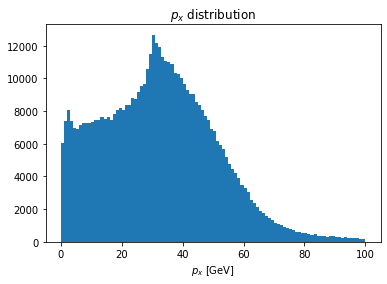

In [4]:
import matplotlib.pyplot as plt
import awkward as ak

plt.hist(ak.flatten(v_jets.px), bins=100, range=(0, 100))
plt.xlabel('$p_x$ [GeV]')
plt.title('$p_x$ distribution')
plt.show()

We can also bring to bear more of the tools in the python physics ecosystem to make a nicer plot!

c:\Users\gordo\Code\iris-hep\func_adl_usage\.venv\lib\site-packages\mplhep\utils.py:211: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  warnings.warn(


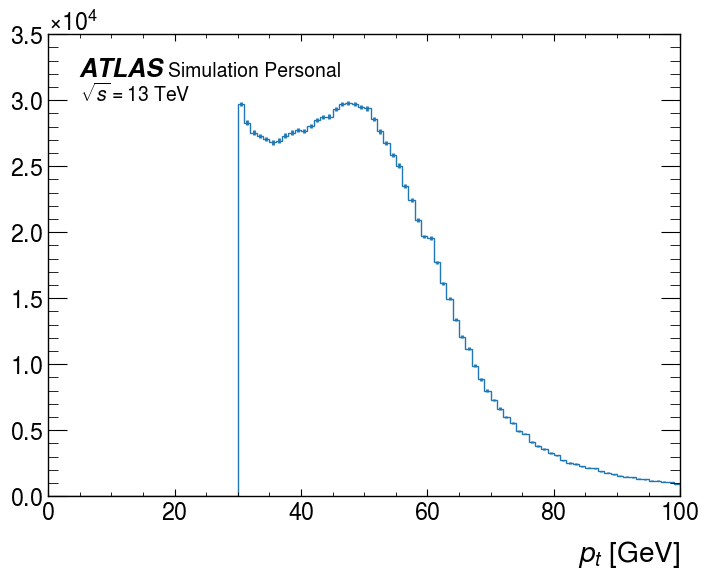

In [5]:
import vector
vector.register_awkward()

v_jets_v = ak.Array(v_jets, with_name='Momentum3D')

import mplhep as hep
hep.style.use(hep.style.ATLAS)
hep.atlas.label("Personal", data=False)

from hist import Hist

h = (
  Hist.new
  .Reg(100, 0 , 100, name="pt", label="$p_t$ [GeV]")
  .Int64()
)
h.fill(ak.flatten(v_jets_v.pt))
h.plot()
plt.show()

It is also possible to use ServiceX to access xAOD files that are stored locally on your machine. The setup and prerequisites are slightly different, and outlined in this section on [local running](ch-running-locally).

## Accessing a CMS Run 1 AOD File

Here we will read muons from a CMS Run 1 AOD file that is stored on CERN's OpenData infrastructure.

```{note}
In your `servicex.yaml` file make sure that the `name` for the backend is `cms_aod_r21`.
```

In [2]:
from func_adl_servicex import ServiceXSourceCMSRun1AOD

ds_cms = ServiceXSourceCMSRun1AOD('cernopendata://1507')

The `ServiceXSourceCMSRun1AOD` is the data source. A cern open-data dataset. It has 22 of files in it - it is Standard Model $H \rightarrow ZZ$ decays (part of their initial release from Run 1).

Above we used a dataset name prefixed with `rucio://` - that told the system to use `rucio` to lookup the files. Here we used `cernopendata://` as the prefix. That tells ServiceX to find the files from CERN's OpenData portal. Each dataset there is given a number - in this case it is dataset 1507, and its description can be found at [CERN's open data portal](http://opendata.cern.ch/record/1507).

Using code that looks very similar to the ATLAS code, we'll fetch a set of columns of data representing the 3-vector fro muons:

In [6]:
v_jets = (
    ds_cms
    .Select(lambda e: e.Muons("muons"))
    .Select(lambda muons: [m for m in muons if m.pt() > 30])
    .Select(lambda muons: {
        'px': [j.px() for j in muons],
        'py': [j.py() for j in muons],
        'pz': [j.pz() for j in muons],
    })
    .AsAwkwardArray()
    .value()
)

cernopendata://1507:   0%|          | 0/9000000000.0 [00:00]

        cernopendata://1507 Downloaded:   0%|          | 0/9000000000.0 [00:00]

Transform e1a7cae6-97eb-4954-80d2-60f7316625e5 had 22 errors:
  Error transforming file: r
  -> error.
  Error transforming file: r
  -> error.
  Error transforming file: r
  -> error.
  Error transforming file: r
  -> error.
  Error transforming file: r
  -> error.
  Error transforming file: r
  -> error.
  Error transforming file: r
  -> error.
  Error transforming file: r
  -> error.
  Error transforming file: r
  -> error.
  Error transforming file: r
  -> error.
  Error transforming file: r
  -> error.
  Error transforming file: r
  -> error.
  Error transforming file: r
  -> error.
  Error transforming file: r
  -> error.
  Error transforming file: r
  -> error.
  Error transforming file: r
  -> error.
  Error transforming file: r
  -> error.
  Error transforming file: r
  -> error.
  Error transforming file: r
  -> error.
  Error transforming file: r
  -> error.


ServiceXException: (ServiceXException(...), 'Failed to transform all files in e1a7cae6-97eb-4954-80d2-60f7316625e5')

You'll see the same marching ants as we did above in the ATLAS case. This took just a touch under 2 minutes to run on the Chicago cluster, with my computer sitting in France. And the query is cached as mentioned above - so a second execution should be fractions of a second.

In [8]:
print(f"Number of events: {len(v_jets)}")

Number of events: 299683


And we can make a very simple plot:

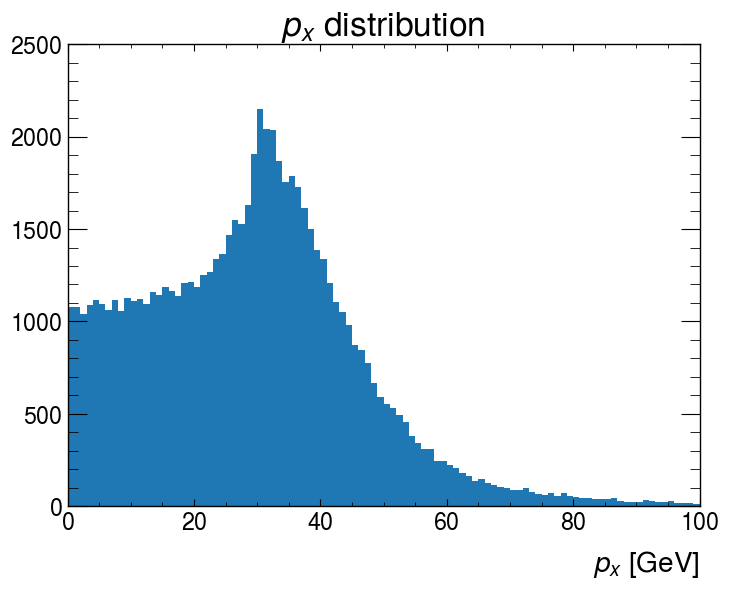

In [9]:
import matplotlib.pyplot as plt
import awkward as ak

plt.hist(ak.flatten(v_jets.px), bins=100, range=(0, 100))
plt.xlabel('$p_x$ [GeV]')
plt.title('$p_x$ distribution')
plt.show()

We can also bring to bear more of the tools in the python physics ecosystem to make a nicer plot!

c:\Users\gordo\Code\iris-hep\func_adl_usage\.venv\lib\site-packages\mplhep\utils.py:211: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  warnings.warn(


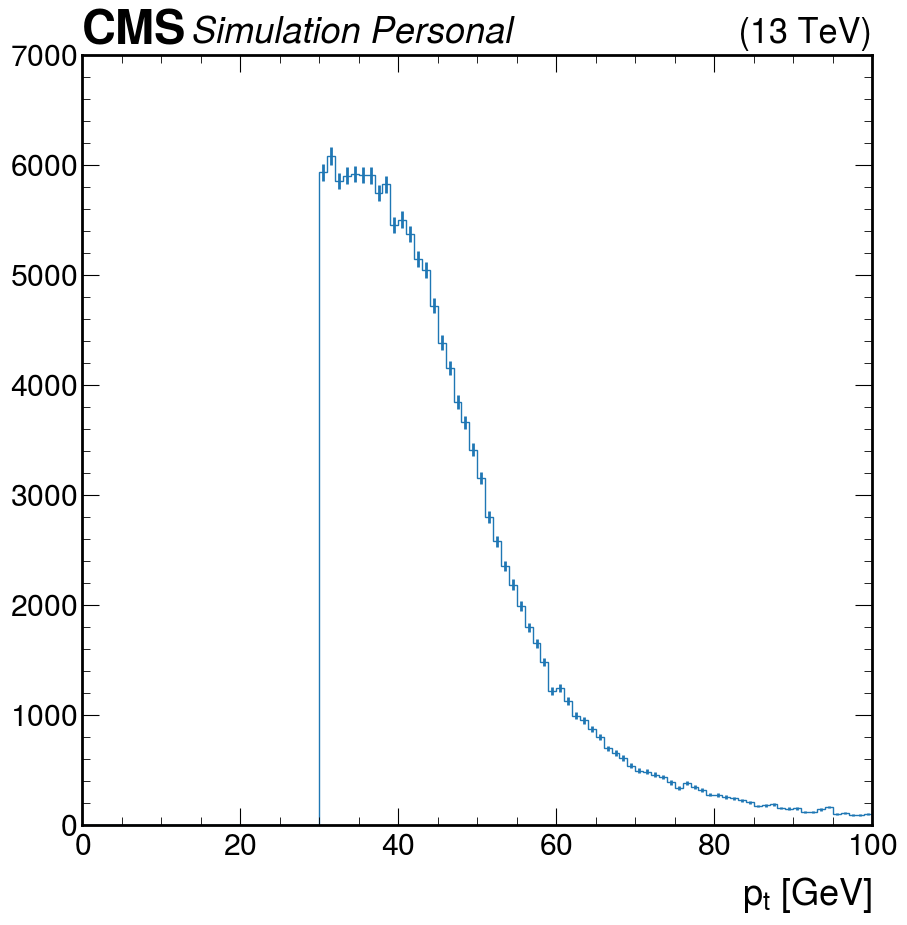

In [10]:
import vector
vector.register_awkward()

v_jets_v = ak.Array(v_jets, with_name='Momentum3D')

import mplhep as hep
hep.style.use(hep.style.CMS)
hep.cms.label("Personal", data=False)

from hist import Hist

h = (
  Hist.new
  .Reg(100, 0 , 100, name="pt", label="$p_t$ [GeV]")
  .Int64()
)
h.fill(ak.flatten(v_jets_v.pt))
h.plot()
plt.show()